In [6]:
import pandas as pd
import sys
import os

root = os.path.abspath(os.path.join('..'))
if root not in sys.path:
    sys.path.append(root)

from src.metrics import regression_metrics
from src.models.prophet_model import train_prophet_model, predict


In [7]:
metrics = pd.read_csv("../data/processed/metrics_full.csv")
metrics["timestamp"] = pd.to_datetime(metrics["timestamp"])
metrics = metrics.set_index("timestamp")

metrics.index = metrics.index.tz_localize(None)

metrics.shape


(89255, 25)

In [8]:
TARGETS = ["requests", "bytes"]

HORIZONS = {
    "1m": 1,
    "5m": 5,
    "15m": 15
}

SPLIT_DATE = "1995-08-23"

results = []


In [9]:
for target in TARGETS:
    print(f"\nTraining Prophet | Target={target}")

    series = metrics[target]

    train_series = series[series.index < SPLIT_DATE]
    test_series = series[series.index >= SPLIT_DATE]

    df_train = (
        train_series
        .reset_index()
        .rename(columns={"timestamp": "ds", target: "y"})
    )

    model = train_prophet_model(df_train)

    forecast = predict(
        model,
        periods=len(test_series),
        freq="min"
    )

    yhat = forecast["yhat"].values[-len(test_series):]

    for window_name, horizon in HORIZONS.items():

        y_true = test_series[horizon:].values
        y_pred = yhat[:-horizon]

        scores = regression_metrics(y_true, y_pred)

        results.append({
            "Model": "Prophet",
            "Target": target,
            "Window": window_name,
            **scores
        })



Training Prophet | Target=requests


16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:13 - cmdstanpy - INFO - Chain [1] done processing



Training Prophet | Target=bytes


16:12:50 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
results_df = pd.DataFrame(results)
results_df


,Model,Target,Window,RMSE,MSE,MAE,MAPE (%)
0,Prophet,requests,1m,21.465633,4.607734e+02,15.985757,9.574320e+06
1,Prophet,requests,5m,21.493106,4.619536e+02,15.998622,9.591082e+06
2,Prophet,requests,15m,21.591944,4.662121e+02,16.058348,9.640592e+06
3,Prophet,bytes,1m,539428.510655,2.909831e+11,373911.040010,1.886667e+11
4,Prophet,bytes,5m,539669.986121,2.912437e+11,374099.555931,1.894142e+11
5,Prophet,bytes,15m,540281.207859,2.919038e+11,374753.364765,1.916949e+11


In [11]:
results_df.to_csv(
    "../data/processed/prophet_benchmark_results.csv",
    index=False
)


16:14:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing


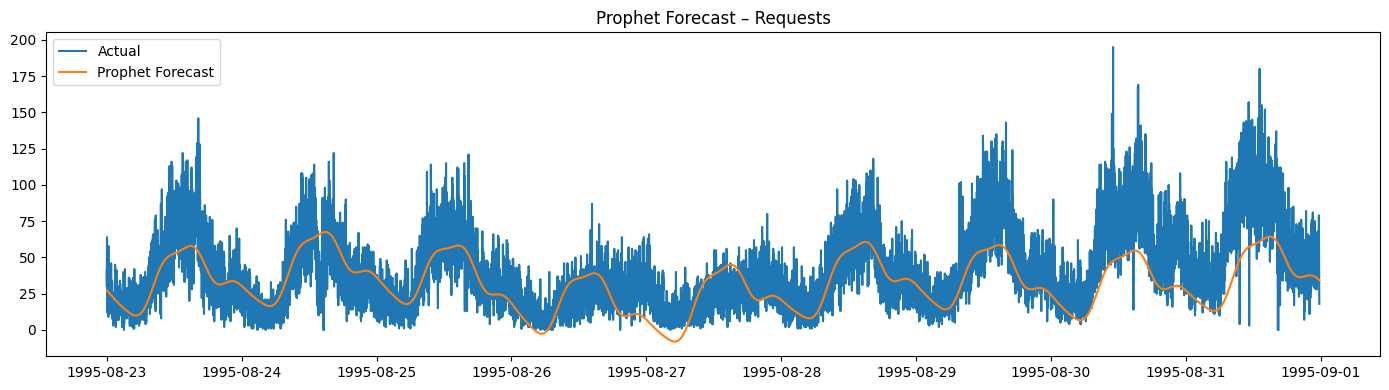

In [12]:
import matplotlib.pyplot as plt

target = "requests"

series = metrics[target]
train_series = series[series.index < SPLIT_DATE]
test_series = series[series.index >= SPLIT_DATE]

df_train = (
    train_series
    .reset_index()
    .rename(columns={"timestamp": "ds", target: "y"})
)

model = train_prophet_model(df_train)

forecast = predict(
    model,
    periods=len(test_series),
    freq="min"
)

yhat = forecast["yhat"].values[-len(test_series):]

plt.figure(figsize=(14,4))
plt.plot(test_series.index, test_series.values, label="Actual")
plt.plot(test_series.index, yhat, label="Prophet Forecast")
plt.title("Prophet Forecast – Requests")
plt.legend()
plt.tight_layout()
plt.show()


16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:18:36 - cmdstanpy - INFO - Chain [1] done processing


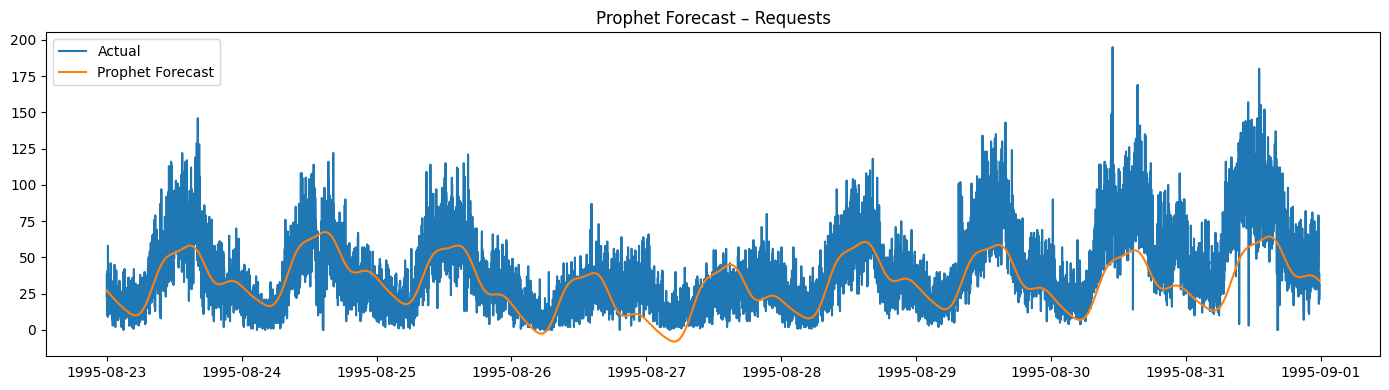

In [13]:
import matplotlib.pyplot as plt

target = "requests_future_5"

series = metrics[target]
train_series = series[series.index < SPLIT_DATE]
test_series = series[series.index >= SPLIT_DATE]

df_train = (
    train_series
    .reset_index()
    .rename(columns={"timestamp": "ds", target: "y"})
)

model = train_prophet_model(df_train)

forecast = predict(
    model,
    periods=len(test_series),
    freq="min"
)

yhat = forecast["yhat"].values[-len(test_series):]

plt.figure(figsize=(14,4))
plt.plot(test_series.index, test_series.values, label="Actual")
plt.plot(test_series.index, yhat, label="Prophet Forecast")
plt.title("Prophet Forecast – Requests")
plt.legend()
plt.tight_layout()
plt.show()
